In [13]:
import uproot
import ROOT
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('default')
plt.rcParams['grid.linestyle'] = ':'

In [49]:
def extract_teffi(eff):
    _ = ROOT.TCanvas()
    eff.Draw()
    ROOT.gPad.Update()
    
    tot = eff.GetTotalHistogram()
    nBins = tot.GetNbinsX()
    xx = []
    yy = []
    yl = []
    yu = []
    for i in range(1, nBins+1):
        if eff.GetEfficiency(eff.GetGlobalBin(i)) == 0 and eff.GetEfficiencyErrorUp(eff.GetGlobalBin(i)) == 1.: continue
        if eff.GetEfficiency(eff.GetGlobalBin(i)) == 1. and eff.GetEfficiencyErrorLow(eff.GetGlobalBin(i)) == 1.: continue
        
        xx.append(tot.GetXaxis().GetBinCenter(i))
        yy.append(eff.GetEfficiency(eff.GetGlobalBin(i)))
        yl.append(eff.GetEfficiencyErrorLow(eff.GetGlobalBin(i)))
        yu.append(eff.GetEfficiencyErrorUp(eff.GetGlobalBin(i)))
                  
    
    return {'x': np.array(xx),
            'y': np.array(yy),
            'yerr': np.array([yl, yu])}

Fit function $f(x) = \frac{1}{1+e^{-p_{0} (x - p_{1})}}  p_{2} + p_{3}$

In [3]:
def extract_fitParam_from_teffi(eff):
    _ = ROOT.TCanvas()
    eff.Draw()
    
    myfit = ROOT.TF1('myfit_', '[2]/(1+exp(-[0]*(x-[1]))) + [3]', 5, 80)
    myfit.SetParameters(0.02, 15, 0.6, 0.1)
    eff.Fit(myfit)

    return [myfit.GetParameter(i) for i in range(4)]


## Trigger `HLT_DoubleL2Mu23NoVtx_2Cha`

In [51]:
from collections import OrderedDict

DL2Mu23T = OrderedDict({
    0.1 : uproot.open('../Firefighter/washAOD/test/2018/SIDMmumu_Mps-200_MZp-1p2_ctau-1p20e-03.root')['TRIG_dsa_DL2Mu23/trigEffiForMuTrack'],
      1 : uproot.open('../Firefighter/washAOD/test/2018/SIDMmumu_Mps-200_MZp-1p2_ctau-0p012.root')   ['TRIG_dsa_DL2Mu23/trigEffiForMuTrack'],
     10 : uproot.open('../Firefighter/washAOD/test/2018/SIDMmumu_Mps-200_MZp-1p2_ctau-0p12.root')    ['TRIG_dsa_DL2Mu23/trigEffiForMuTrack'],
     50 : uproot.open('../Firefighter/washAOD/test/2018/SIDMmumu_Mps-200_MZp-1p2_ctau-0p6.root')     ['TRIG_dsa_DL2Mu23/trigEffiForMuTrack'],
    100 : uproot.open('../Firefighter/washAOD/test/2018/SIDMmumu_Mps-200_MZp-1p2_ctau-1p2.root')     ['TRIG_dsa_DL2Mu23/trigEffiForMuTrack'],
    300 : uproot.open('../Firefighter/washAOD/test/2018/SIDMmumu_Mps-200_MZp-1p2_ctau-3p6.root')     ['TRIG_dsa_DL2Mu23/trigEffiForMuTrack']     
})

In [52]:
DL2Mu23T[1].keys()

[b'fired', b'pt', b'eta', b'phi']

In [53]:
_dict = {}
for k, t in DL2Mu23T.items():
    _counts = t.pandas.df(['fired'])[b'fired'].value_counts()
    _counts /= _counts.sum()
    _dict[k] = _counts
pd.DataFrame(_dict)

,0.1,1.0,10.0,50.0,100.0,300.0
True,0.826863,0.832451,0.830294,0.817674,0.812707,0.784684
False,0.173137,0.167549,0.169706,0.182326,0.187293,0.215316


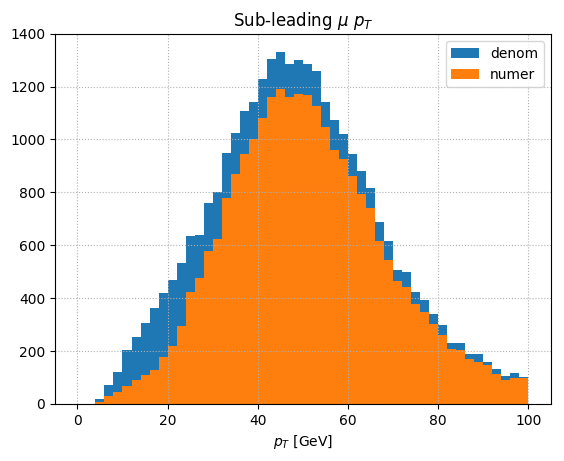

In [54]:
t = DL2Mu23T[1]
pt = t.array('pt')
start = pt.starts
denom = pt.content[start+1]
fd = t.array('fired')
numer = pt.content[start[fd]+1]
fig,ax = plt.subplots()
ax.hist(denom, bins=50, range=(0,100), label='denom')
ax.hist(numer, bins=50, range=(0,100), label='numer')
ax.legend(loc='best')
ax.set_title('Sub-leading $\mu$ $p_{T}$')
ax.set_xlabel('$p_{T}$ [GeV]')
ax.grid()

### Trigger `HLT_DoubleL2Mu23NoVtx_2Cha` Efficiency as a function of sub-leading $\mu$ $p_{T}$

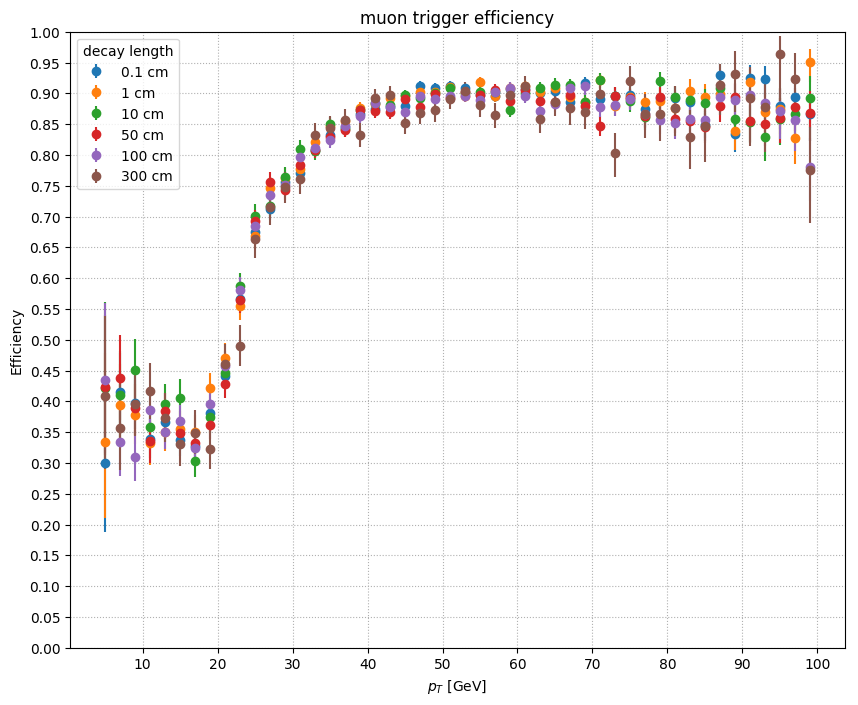

In [55]:
fig,ax = plt.subplots(figsize=(10,8))

for k, t in DL2Mu23T.items():
    d = t.array('pt')
    start = d.starts
    denom = d.content[start+1]
    fd = t.array('fired')
    numer = d.content[start[fd]+1]
    
    h0 = ROOT.TH1F(f'h0_{k}', '', 50, 0, 100)
    h1 = ROOT.TH1F(f'h1_{k}', '', 50, 0, 100)
    for x in np.nditer(denom): h0.Fill(x)
    for x in np.nditer(numer): h1.Fill(x)
        
    eff = ROOT.TEfficiency(h1, h0)
    data = extract_teffi(eff)

    ax.errorbar(x=data['x'], y=data['y'], yerr=data['yerr'], fmt='o', label=f'{k} cm')
    
ax.set_title('muon trigger efficiency')
ax.set_xlabel('$p_{T}$ [GeV]')
ax.set_ylabel('Efficiency')
ax.xaxis.set_major_locator(plt.MaxNLocator(12))
ax.yaxis.set_major_locator(plt.MaxNLocator(20))
ax.set_ylim((0,1))
ax.legend(loc='best', title='decay length')
ax.grid()

### Trigger `HLT_DoubleL2Mu23NoVtx_2Cha` Efficiency as a function of sub-leading $\mu$ $\eta$

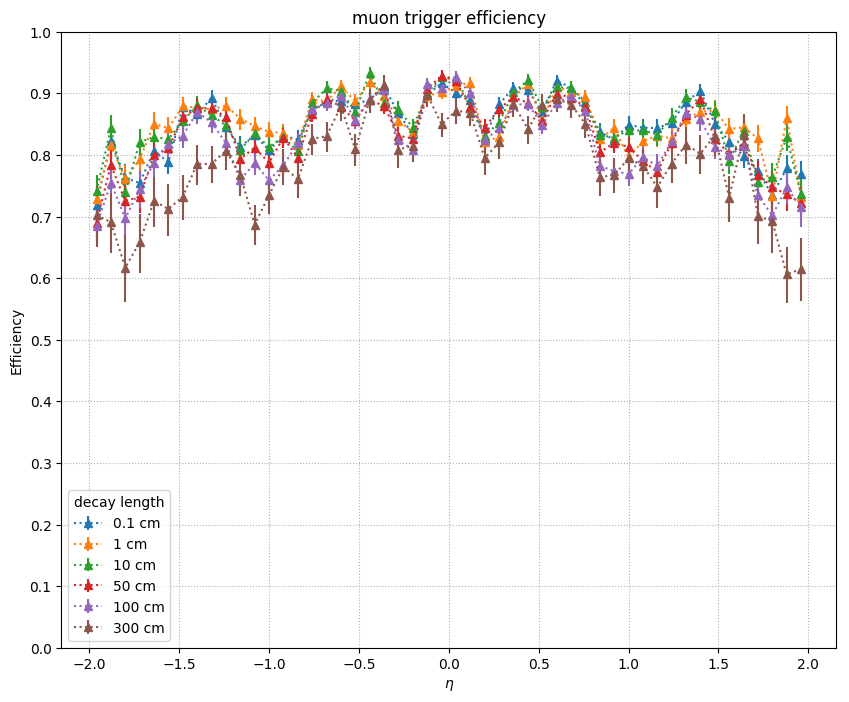

In [56]:
fig,ax = plt.subplots(figsize=(10,8))

for k, t in DL2Mu23T.items():
    d = t.array('eta')
    start = d.starts
    denom = d.content[start+1]
    fd = t.array('fired')
    numer = d.content[start[fd]+1]
    
    h0 = ROOT.TH1F(f'h0_{k}', '', 50, -2., 2.)
    h1 = ROOT.TH1F(f'h1_{k}', '', 50, -2., 2.)
    for x in np.nditer(denom): h0.Fill(x)
    for x in np.nditer(numer): h1.Fill(x)
        
    eff = ROOT.TEfficiency(h1, h0)
    data = extract_teffi(eff)

    ax.errorbar(x=data['x'], y=data['y'], yerr=data['yerr'], fmt='^:', label=f'{k} cm')
    
ax.set_title('muon trigger efficiency')
ax.set_xlabel('$\eta$')
ax.set_ylabel('Efficiency')
ax.yaxis.set_major_locator(plt.MaxNLocator(10))
ax.set_ylim((0,1))
ax.legend(loc='best', title='decay length')
ax.grid()

### trigger efficiency of itself

In [57]:
from collections import OrderedDict

DL2Mu23T = OrderedDict({
    0.1 : uproot.open('../Firefighter/washAOD/test/2018/SIDMmumu_Mps-200_MZp-1p2_ctau-1p20e-03.root')['TRIGself_dsa_DL2Mu23/trigSelfEffiForMuTrack'],
      1 : uproot.open('../Firefighter/washAOD/test/2018/SIDMmumu_Mps-200_MZp-1p2_ctau-0p012.root')   ['TRIGself_dsa_DL2Mu23/trigSelfEffiForMuTrack'],
     10 : uproot.open('../Firefighter/washAOD/test/2018/SIDMmumu_Mps-200_MZp-1p2_ctau-0p12.root')    ['TRIGself_dsa_DL2Mu23/trigSelfEffiForMuTrack'],
     50 : uproot.open('../Firefighter/washAOD/test/2018/SIDMmumu_Mps-200_MZp-1p2_ctau-0p6.root')     ['TRIGself_dsa_DL2Mu23/trigSelfEffiForMuTrack'],
    100 : uproot.open('../Firefighter/washAOD/test/2018/SIDMmumu_Mps-200_MZp-1p2_ctau-1p2.root')     ['TRIGself_dsa_DL2Mu23/trigSelfEffiForMuTrack'],
    300 : uproot.open('../Firefighter/washAOD/test/2018/SIDMmumu_Mps-200_MZp-1p2_ctau-3p6.root')     ['TRIGself_dsa_DL2Mu23/trigSelfEffiForMuTrack']     
})

0.1      0.931387
1.0      0.932071
10.0     0.930657
50.0     0.917863
100.0    0.905938
300.0    0.843255
dtype: float64


Info in <TBinomialEfficiencyFitter::result>:  chi2 164.556759 ndf 0 
Info in <TBinomialEfficiencyFitter::result>:  chi2 118.964909 ndf 0 
Info in <TBinomialEfficiencyFitter::result>:  chi2 174.184006 ndf 0 
Info in <TBinomialEfficiencyFitter::result>:  chi2 144.123231 ndf 0 
Info in <TBinomialEfficiencyFitter::result>:  chi2 137.155843 ndf 0 
Info in <TBinomialEfficiencyFitter::result>:  chi2 112.473467 ndf 0 


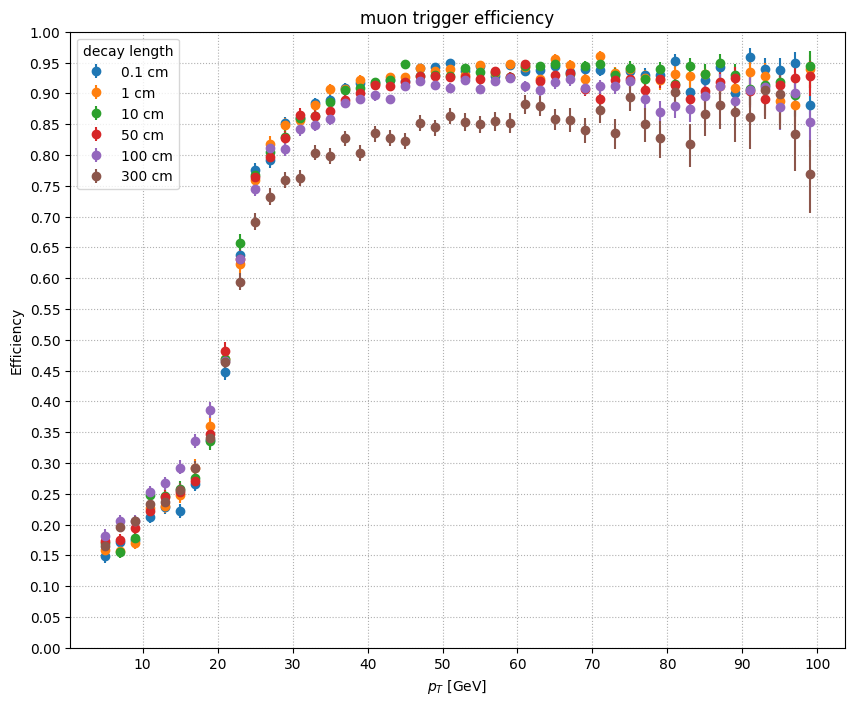

In [58]:
fig,ax = plt.subplots(figsize=(10,8))

fitResult = {}
for k, t in DL2Mu23T.items():
    d = t.array('pt')
    start = d.starts
    denom = d.content[start+1]
    fd = t.array('fired')
    numer = d.content[start[fd]+1]
    
    h0 = ROOT.TH1F(f'h0_{k}', '', 50, 0, 100)
    h1 = ROOT.TH1F(f'h1_{k}', '', 50, 0, 100)
    for x in np.nditer(denom): h0.Fill(x)
    for x in np.nditer(numer): h1.Fill(x)
        
    eff = ROOT.TEfficiency(h1, h0)
    data = extract_teffi(eff)
    fitResult[k] = extract_fitParam_from_teffi(eff)

    ax.errorbar(x=data['x'], y=data['y'], yerr=data['yerr'], fmt='o', label=f'{k} cm')
    
ax.set_title('muon trigger efficiency')
ax.set_xlabel('$p_{T}$ [GeV]')
ax.set_ylabel('Efficiency')
ax.xaxis.set_major_locator(plt.MaxNLocator(12))
ax.yaxis.set_major_locator(plt.MaxNLocator(20))
ax.set_ylim((0,1))
ax.legend(loc='best', title='decay length')
ax.grid()

print(pd.Series({k: fitResult[k][2]+fitResult[k][3] for k in fitResult}))

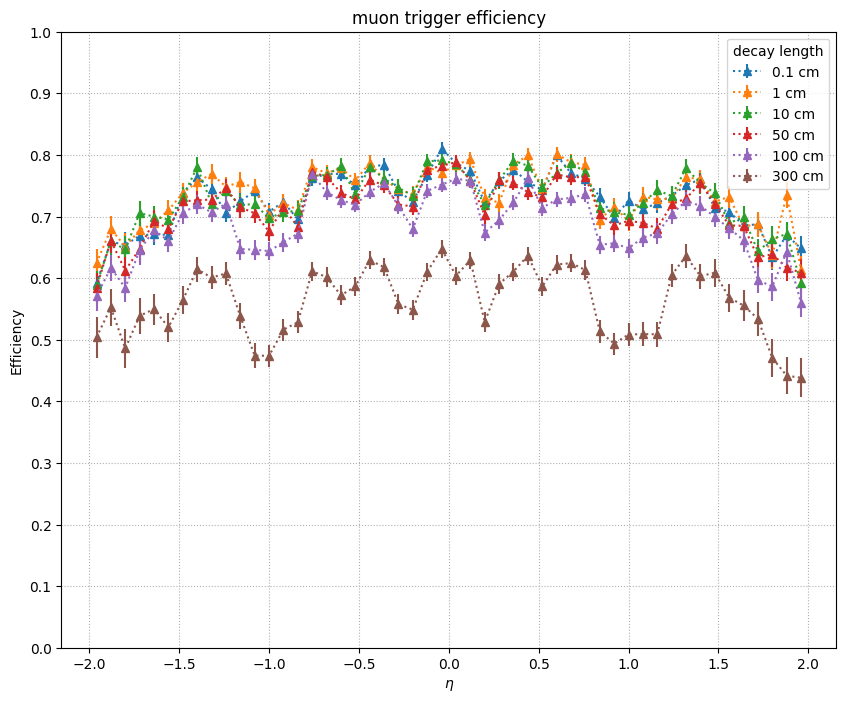

In [59]:
fig,ax = plt.subplots(figsize=(10,8))

for k, t in DL2Mu23T.items():
    d = t.array('eta')
    start = d.starts
    denom = d.content[start+1]
    fd = t.array('fired')
    numer = d.content[start[fd]+1]
    
    h0 = ROOT.TH1F(f'h0_{k}', '', 50, -2., 2.)
    h1 = ROOT.TH1F(f'h1_{k}', '', 50, -2., 2.)
    for x in np.nditer(denom): h0.Fill(x)
    for x in np.nditer(numer): h1.Fill(x)
        
    eff = ROOT.TEfficiency(h1, h0)
    data = extract_teffi(eff)

    ax.errorbar(x=data['x'], y=data['y'], yerr=data['yerr'], fmt='^:', label=f'{k} cm')
    
ax.set_title('muon trigger efficiency')
ax.set_xlabel('$\eta$')
ax.set_ylabel('Efficiency')
ax.yaxis.set_major_locator(plt.MaxNLocator(10))
ax.set_ylim((0,1))
ax.legend(loc='best', title='decay length')
ax.grid()

## Trigger `HLT_DoubleL2Mu23NoVtx_2Cha_NoL2Matched`

In [60]:
DL2Mu23NoL2T = OrderedDict({
    0.1 : uproot.open('../Firefighter/washAOD/test/2018/SIDMmumu_Mps-200_MZp-1p2_ctau-1p20e-03.root')['TRIG_dsa_DL2Mu23NoL2/trigEffiForMuTrack'],
      1 : uproot.open('../Firefighter/washAOD/test/2018/SIDMmumu_Mps-200_MZp-1p2_ctau-0p012.root')   ['TRIG_dsa_DL2Mu23NoL2/trigEffiForMuTrack'],
     10 : uproot.open('../Firefighter/washAOD/test/2018/SIDMmumu_Mps-200_MZp-1p2_ctau-0p12.root')    ['TRIG_dsa_DL2Mu23NoL2/trigEffiForMuTrack'],
     50 : uproot.open('../Firefighter/washAOD/test/2018/SIDMmumu_Mps-200_MZp-1p2_ctau-0p6.root')     ['TRIG_dsa_DL2Mu23NoL2/trigEffiForMuTrack'],
    100 : uproot.open('../Firefighter/washAOD/test/2018/SIDMmumu_Mps-200_MZp-1p2_ctau-1p2.root')     ['TRIG_dsa_DL2Mu23NoL2/trigEffiForMuTrack'],
    300 : uproot.open('../Firefighter/washAOD/test/2018/SIDMmumu_Mps-200_MZp-1p2_ctau-3p6.root')     ['TRIG_dsa_DL2Mu23NoL2/trigEffiForMuTrack']     
})

In [61]:
import pandas as pd
_dict = {}
for k, t in DL2Mu23NoL2T.items():
    _counts = t.pandas.df(['fired'])[b'fired'].value_counts()
    _counts /= _counts.sum()
    _dict[k] = _counts
pd.DataFrame(_dict)

,0.1,1.0,10.0,50.0,100.0,300.0
True,0.828568,0.834575,0.832428,0.820294,0.815807,0.786756
False,0.171432,0.165425,0.167572,0.179706,0.184193,0.213244


### Trigger `HLT_DoubleL2Mu23NoVtx_2Cha_NoL2Matched` Efficiency as a function of sub-leading $\mu$ $p_{T}$

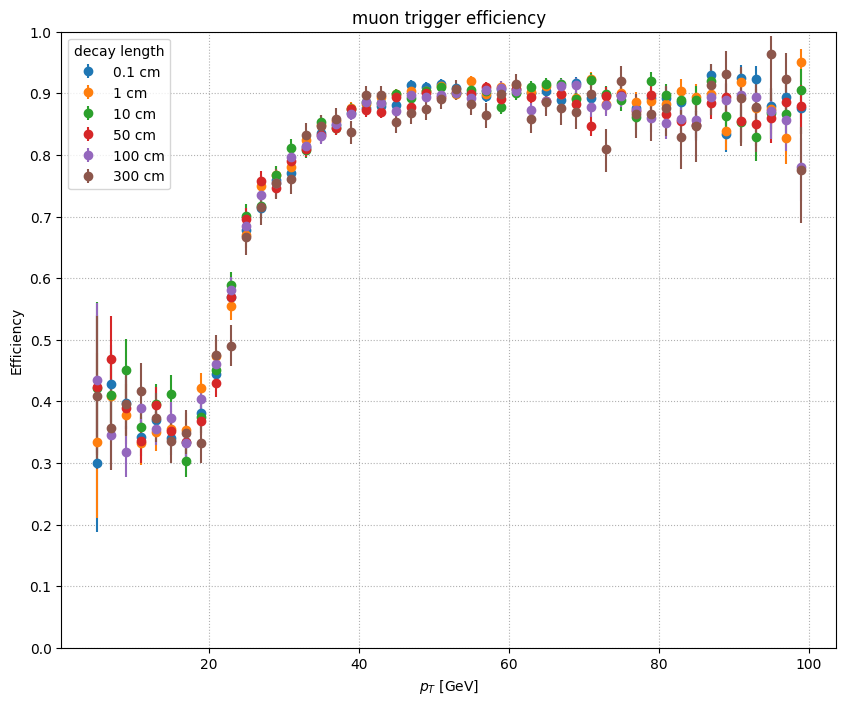

In [62]:
fig,ax = plt.subplots(figsize=(10,8))

for k, t in DL2Mu23NoL2T.items():
    d = t.array('pt')
    start = d.starts
    denom = d.content[start+1]
    fd = t.array('fired')
    numer = d.content[start[fd]+1]
    
    h0 = ROOT.TH1F(f'h0_{k}', '', 50, 0, 100)
    h1 = ROOT.TH1F(f'h1_{k}', '', 50, 0, 100)
    for x in np.nditer(denom): h0.Fill(x)
    for x in np.nditer(numer): h1.Fill(x)
        
    eff = ROOT.TEfficiency(h1, h0)
    data = extract_teffi(eff)

    ax.errorbar(x=data['x'], y=data['y'], yerr=data['yerr'], fmt='o', label=f'{k} cm')
    
ax.set_title('muon trigger efficiency')
ax.set_xlabel('$p_{T}$ [GeV]')
ax.set_ylabel('Efficiency')
ax.yaxis.set_major_locator(plt.MaxNLocator(10))
ax.set_ylim((0,1))
ax.legend(loc='best', title='decay length')
ax.grid()

### Trigger `HLT_DoubleL2Mu23NoVtx_2Cha_NoL2Matched` Efficiency as a function of sub-leading $\mu$ $\eta$

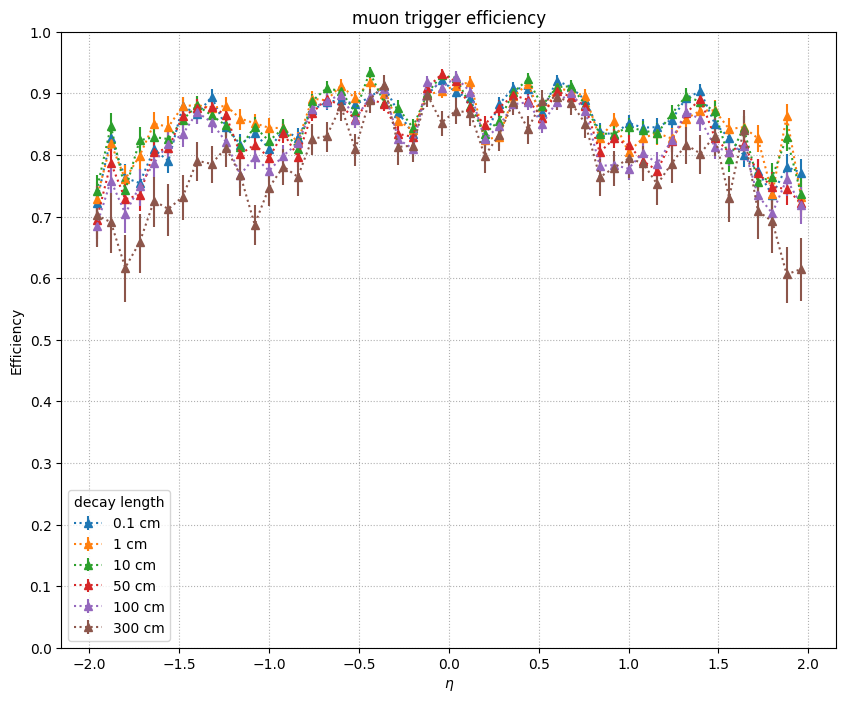

In [63]:
fig,ax = plt.subplots(figsize=(10,8))

for k, t in DL2Mu23NoL2T.items():
    d = t.array('eta')
    start = d.starts
    denom = d.content[start+1]
    fd = t.array('fired')
    numer = d.content[start[fd]+1]
    
    h0 = ROOT.TH1F(f'h0_{k}', '', 50, -2., 2.)
    h1 = ROOT.TH1F(f'h1_{k}', '', 50, -2., 2.)
    for x in np.nditer(denom): h0.Fill(x)
    for x in np.nditer(numer): h1.Fill(x)
        
    eff = ROOT.TEfficiency(h1, h0)
    data = extract_teffi(eff)

    ax.errorbar(x=data['x'], y=data['y'], yerr=data['yerr'], fmt='^:', label=f'{k} cm')
    
ax.set_title('muon trigger efficiency')
ax.set_xlabel('$\eta$')
ax.set_ylabel('Efficiency')
ax.yaxis.set_major_locator(plt.MaxNLocator(10))
ax.set_ylim((0,1))
ax.legend(loc='best', title='decay length')
ax.grid()

### trigger efficiency itself

In [64]:
DL2Mu23NoL2T = OrderedDict({
    0.1 : uproot.open('../Firefighter/washAOD/test/2018/SIDMmumu_Mps-200_MZp-1p2_ctau-1p20e-03.root')['TRIGself_dsa_DL2Mu23NoL2/trigSelfEffiForMuTrack'],
      1 : uproot.open('../Firefighter/washAOD/test/2018/SIDMmumu_Mps-200_MZp-1p2_ctau-0p012.root')   ['TRIGself_dsa_DL2Mu23NoL2/trigSelfEffiForMuTrack'],
     10 : uproot.open('../Firefighter/washAOD/test/2018/SIDMmumu_Mps-200_MZp-1p2_ctau-0p12.root')    ['TRIGself_dsa_DL2Mu23NoL2/trigSelfEffiForMuTrack'],
     50 : uproot.open('../Firefighter/washAOD/test/2018/SIDMmumu_Mps-200_MZp-1p2_ctau-0p6.root')     ['TRIGself_dsa_DL2Mu23NoL2/trigSelfEffiForMuTrack'],
    100 : uproot.open('../Firefighter/washAOD/test/2018/SIDMmumu_Mps-200_MZp-1p2_ctau-1p2.root')     ['TRIGself_dsa_DL2Mu23NoL2/trigSelfEffiForMuTrack'],
    300 : uproot.open('../Firefighter/washAOD/test/2018/SIDMmumu_Mps-200_MZp-1p2_ctau-3p6.root')     ['TRIGself_dsa_DL2Mu23NoL2/trigSelfEffiForMuTrack']     
})

0.1      0.933000
1.0      0.933949
10.0     0.932275
50.0     0.919285
100.0    0.908945
300.0    0.849741
dtype: float64


Info in <TBinomialEfficiencyFitter::result>:  chi2 168.003505 ndf 0 
Info in <TBinomialEfficiencyFitter::result>:  chi2 118.298974 ndf 0 
Info in <TBinomialEfficiencyFitter::result>:  chi2 171.275650 ndf 0 
Info in <TBinomialEfficiencyFitter::result>:  chi2 148.003602 ndf 0 
Info in <TBinomialEfficiencyFitter::result>:  chi2 134.872221 ndf 0 
Info in <TBinomialEfficiencyFitter::result>:  chi2 103.831778 ndf 0 


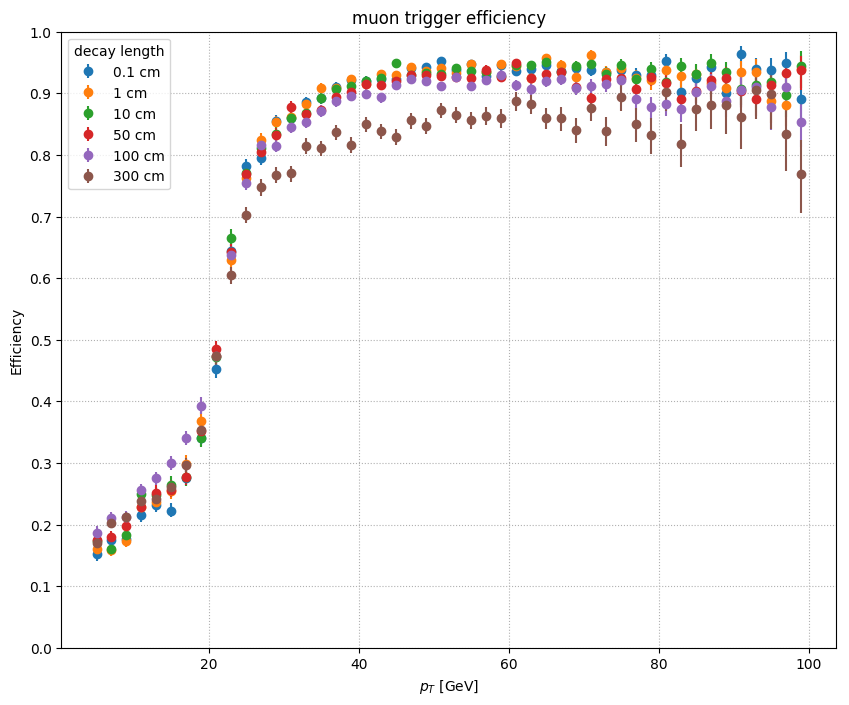

In [65]:
fig,ax = plt.subplots(figsize=(10,8))

fitResult = {}
for k, t in DL2Mu23NoL2T.items():
    d = t.array('pt')
    start = d.starts
    denom = d.content[start+1]
    fd = t.array('fired')
    numer = d.content[start[fd]+1]
    
    h0 = ROOT.TH1F(f'h0_{k}', '', 50, 0, 100)
    h1 = ROOT.TH1F(f'h1_{k}', '', 50, 0, 100)
    for x in np.nditer(denom): h0.Fill(x)
    for x in np.nditer(numer): h1.Fill(x)
        
    eff = ROOT.TEfficiency(h1, h0)
    data = extract_teffi(eff)
    fitResult[k] = extract_fitParam_from_teffi(eff)

    ax.errorbar(x=data['x'], y=data['y'], yerr=data['yerr'], fmt='o', label=f'{k} cm')
    
ax.set_title('muon trigger efficiency')
ax.set_xlabel('$p_{T}$ [GeV]')
ax.set_ylabel('Efficiency')
ax.yaxis.set_major_locator(plt.MaxNLocator(10))
ax.set_ylim((0,1))
ax.legend(loc='best', title='decay length')
ax.grid()

print(pd.Series({k: fitResult[k][2]+fitResult[k][3] for k in fitResult}))

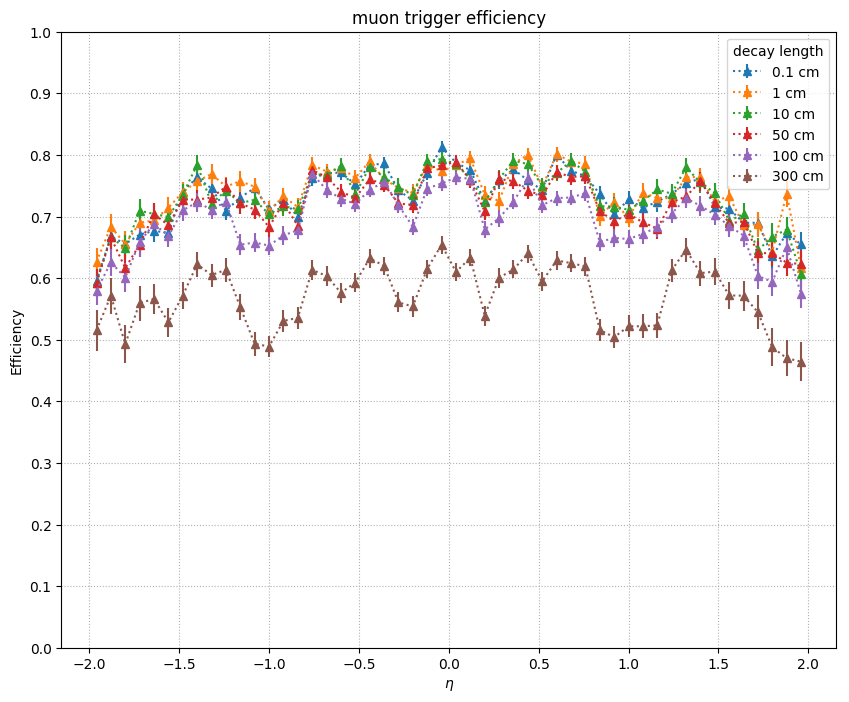

In [66]:
fig,ax = plt.subplots(figsize=(10,8))

for k, t in DL2Mu23NoL2T.items():
    d = t.array('eta')
    start = d.starts
    denom = d.content[start+1]
    fd = t.array('fired')
    numer = d.content[start[fd]+1]
    
    h0 = ROOT.TH1F(f'h0_{k}', '', 50, -2., 2.)
    h1 = ROOT.TH1F(f'h1_{k}', '', 50, -2., 2.)
    for x in np.nditer(denom): h0.Fill(x)
    for x in np.nditer(numer): h1.Fill(x)
        
    eff = ROOT.TEfficiency(h1, h0)
    data = extract_teffi(eff)

    ax.errorbar(x=data['x'], y=data['y'], yerr=data['yerr'], fmt='^:', label=f'{k} cm')
    
ax.set_title('muon trigger efficiency')
ax.set_xlabel('$\eta$')
ax.set_ylabel('Efficiency')
ax.yaxis.set_major_locator(plt.MaxNLocator(10))
ax.set_ylim((0,1))
ax.legend(loc='best', title='decay length')
ax.grid()

## Trigger `HLT_DoubleL2Mu23NoVtx_2Cha_CosmicSeed`

In [67]:
DL2Mu23CosmicT = OrderedDict({
    0.1 : uproot.open('../Firefighter/washAOD/test/2018/SIDMmumu_Mps-200_MZp-1p2_ctau-1p20e-03.root')['TRIG_dsa_DL2Mu23CosmicSeed/trigEffiForMuTrack'],
      1 : uproot.open('../Firefighter/washAOD/test/2018/SIDMmumu_Mps-200_MZp-1p2_ctau-0p012.root')   ['TRIG_dsa_DL2Mu23CosmicSeed/trigEffiForMuTrack'],
     10 : uproot.open('../Firefighter/washAOD/test/2018/SIDMmumu_Mps-200_MZp-1p2_ctau-0p12.root')    ['TRIG_dsa_DL2Mu23CosmicSeed/trigEffiForMuTrack'],
     50 : uproot.open('../Firefighter/washAOD/test/2018/SIDMmumu_Mps-200_MZp-1p2_ctau-0p6.root')     ['TRIG_dsa_DL2Mu23CosmicSeed/trigEffiForMuTrack'],
    100 : uproot.open('../Firefighter/washAOD/test/2018/SIDMmumu_Mps-200_MZp-1p2_ctau-1p2.root')     ['TRIG_dsa_DL2Mu23CosmicSeed/trigEffiForMuTrack'],
    300 : uproot.open('../Firefighter/washAOD/test/2018/SIDMmumu_Mps-200_MZp-1p2_ctau-3p6.root')     ['TRIG_dsa_DL2Mu23CosmicSeed/trigEffiForMuTrack']     
})

In [68]:
import pandas as pd
_dict = {}
for k, t in DL2Mu23CosmicT.items():
    _counts = t.pandas.df(['fired'])[b'fired'].value_counts()
    _counts /= _counts.sum()
    _dict[k] = _counts
pd.DataFrame(_dict)

,0.1,1.0,10.0,50.0,100.0,300.0
True,0.759621,0.763203,0.760392,0.739566,0.721864,0.658897
False,0.240379,0.236797,0.239608,0.260434,0.278136,0.341103


### Trigger `HLT_DoubleL2Mu23NoVtx_2Cha_CosmicSeed` Efficiency as a function of sub-leading $\mu$ $p_{T}$

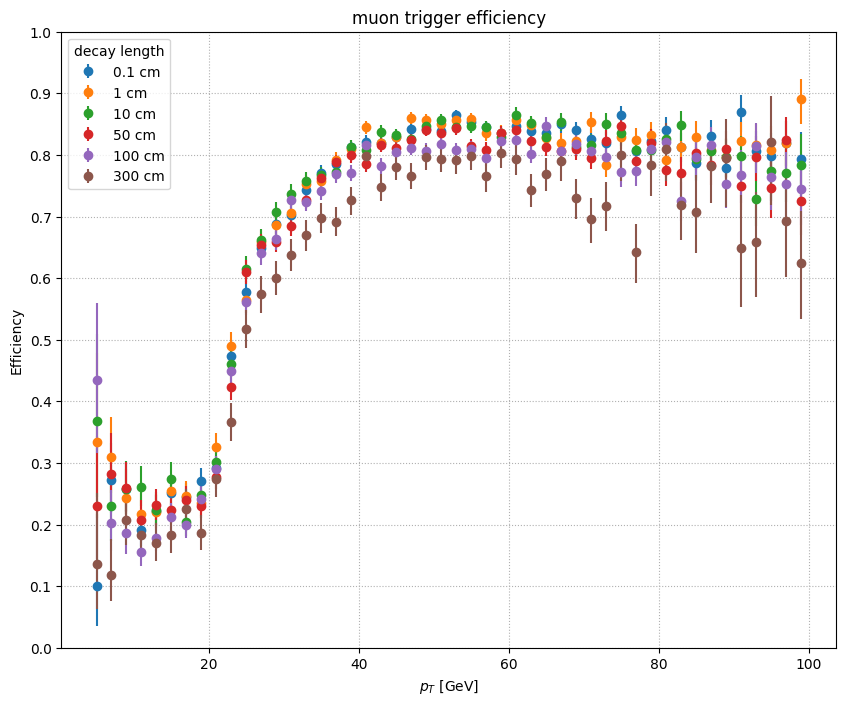

In [69]:
fig,ax = plt.subplots(figsize=(10,8))

for k, t in DL2Mu23CosmicT.items():
    d = t.array('pt')
    start = d.starts
    denom = d.content[start+1]
    fd = t.array('fired')
    numer = d.content[start[fd]+1]
    
    h0 = ROOT.TH1F(f'h0_{k}', '', 50, 0, 100)
    h1 = ROOT.TH1F(f'h1_{k}', '', 50, 0, 100)
    for x in np.nditer(denom): h0.Fill(x)
    for x in np.nditer(numer): h1.Fill(x)
        
    eff = ROOT.TEfficiency(h1, h0)
    data = extract_teffi(eff)

    ax.errorbar(x=data['x'], y=data['y'], yerr=data['yerr'], fmt='o', label=f'{k} cm')
    
ax.set_title('muon trigger efficiency')
ax.set_xlabel('$p_{T}$ [GeV]')
ax.set_ylabel('Efficiency')
ax.yaxis.set_major_locator(plt.MaxNLocator(10))
ax.set_ylim((0,1))
ax.legend(loc='best', title='decay length')
ax.grid()

### Trigger `HLT_DoubleL2Mu23NoVtx_2Cha_CosmicSeed` Efficiency as a function of sub-leading $\mu$ $\eta$

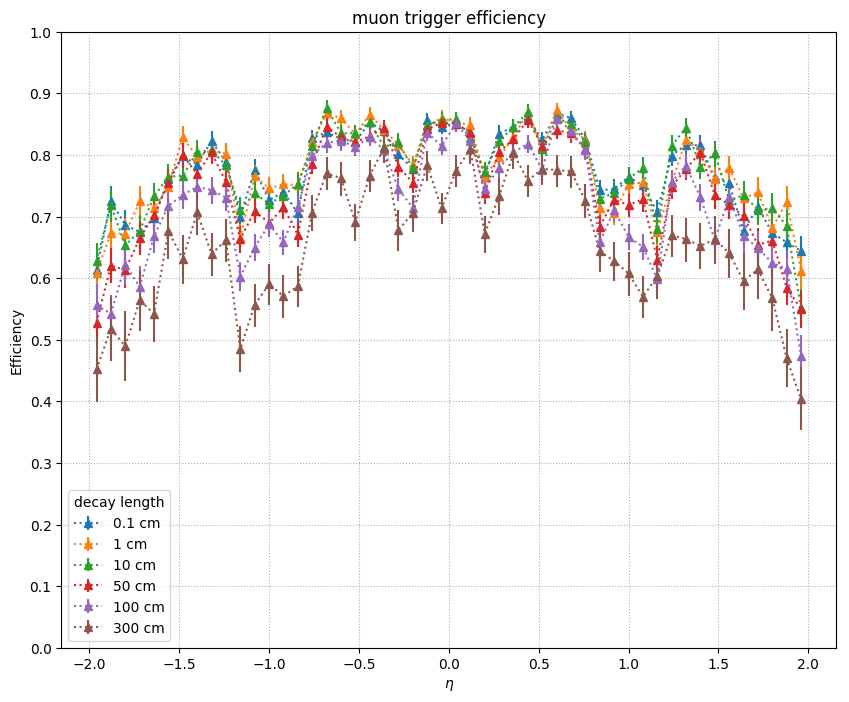

In [70]:
fig,ax = plt.subplots(figsize=(10,8))

for k, t in DL2Mu23CosmicT.items():
    d = t.array('eta')
    start = d.starts
    denom = d.content[start+1]
    fd = t.array('fired')
    numer = d.content[start[fd]+1]
    
    h0 = ROOT.TH1F(f'h0_{k}', '', 50, -2., 2.)
    h1 = ROOT.TH1F(f'h1_{k}', '', 50, -2., 2.)
    for x in np.nditer(denom): h0.Fill(x)
    for x in np.nditer(numer): h1.Fill(x)
        
    eff = ROOT.TEfficiency(h1, h0)
    data = extract_teffi(eff)

    ax.errorbar(x=data['x'], y=data['y'], yerr=data['yerr'], fmt='^:', label=f'{k} cm')
    
ax.set_title('muon trigger efficiency')
ax.set_xlabel('$\eta$')
ax.set_ylabel('Efficiency')
ax.yaxis.set_major_locator(plt.MaxNLocator(10))
ax.set_ylim((0,1))
ax.legend(loc='best', title='decay length')
ax.grid()

### trigger efficiency itself

In [71]:
DL2Mu23CosmicT = OrderedDict({
    0.1 : uproot.open('../Firefighter/washAOD/test/2018/SIDMmumu_Mps-200_MZp-1p2_ctau-1p20e-03.root')['TRIGself_dsa_DL2Mu23CosmicSeed/trigSelfEffiForMuTrack'],
      1 : uproot.open('../Firefighter/washAOD/test/2018/SIDMmumu_Mps-200_MZp-1p2_ctau-0p012.root')   ['TRIGself_dsa_DL2Mu23CosmicSeed/trigSelfEffiForMuTrack'],
     10 : uproot.open('../Firefighter/washAOD/test/2018/SIDMmumu_Mps-200_MZp-1p2_ctau-0p12.root')    ['TRIGself_dsa_DL2Mu23CosmicSeed/trigSelfEffiForMuTrack'],
     50 : uproot.open('../Firefighter/washAOD/test/2018/SIDMmumu_Mps-200_MZp-1p2_ctau-0p6.root')     ['TRIGself_dsa_DL2Mu23CosmicSeed/trigSelfEffiForMuTrack'],
    100 : uproot.open('../Firefighter/washAOD/test/2018/SIDMmumu_Mps-200_MZp-1p2_ctau-1p2.root')     ['TRIGself_dsa_DL2Mu23CosmicSeed/trigSelfEffiForMuTrack'],
    300 : uproot.open('../Firefighter/washAOD/test/2018/SIDMmumu_Mps-200_MZp-1p2_ctau-3p6.root')     ['TRIGself_dsa_DL2Mu23CosmicSeed/trigSelfEffiForMuTrack']     
})

0.1      0.866415
1.0      0.865395
10.0     0.863718
50.0     0.842421
100.0    0.810814
300.0    0.734964
dtype: float64


Info in <TBinomialEfficiencyFitter::result>:  chi2 186.584891 ndf 0 
Info in <TBinomialEfficiencyFitter::result>:  chi2 156.798755 ndf 0 
Info in <TBinomialEfficiencyFitter::result>:  chi2 183.045379 ndf 0 
Info in <TBinomialEfficiencyFitter::result>:  chi2 232.720502 ndf 0 
Info in <TBinomialEfficiencyFitter::result>:  chi2 176.376937 ndf 0 
Info in <TBinomialEfficiencyFitter::result>:  chi2 113.448704 ndf 0 


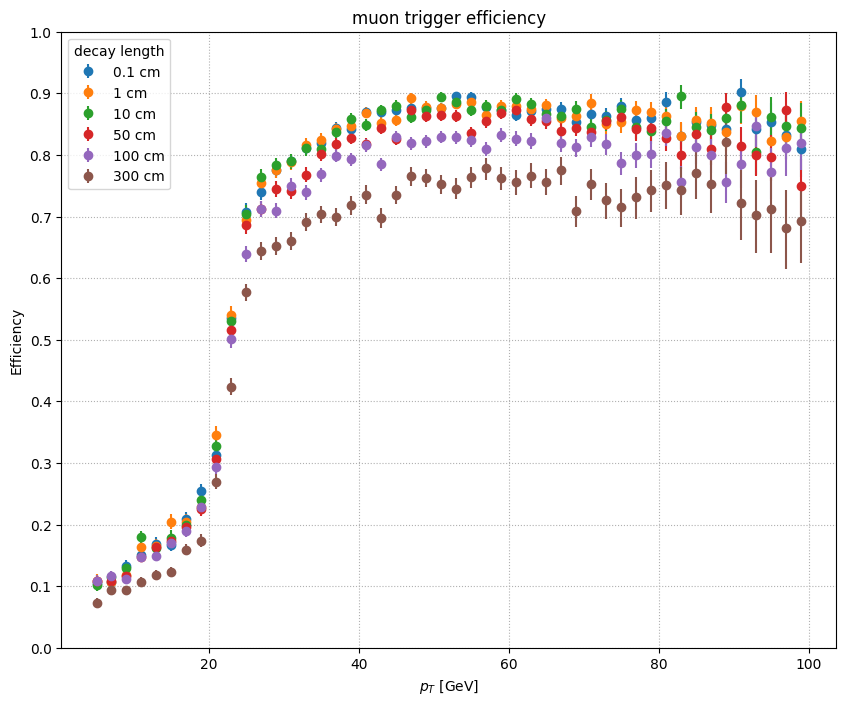

In [72]:
fig,ax = plt.subplots(figsize=(10,8))

fitResult = {}
for k, t in DL2Mu23CosmicT.items():
    d = t.array('pt')
    start = d.starts
    denom = d.content[start+1]
    fd = t.array('fired')
    numer = d.content[start[fd]+1]
    
    h0 = ROOT.TH1F(f'h0_{k}', '', 50, 0, 100)
    h1 = ROOT.TH1F(f'h1_{k}', '', 50, 0, 100)
    for x in np.nditer(denom): h0.Fill(x)
    for x in np.nditer(numer): h1.Fill(x)
        
    eff = ROOT.TEfficiency(h1, h0)
    data = extract_teffi(eff)
    fitResult[k] = extract_fitParam_from_teffi(eff)

    ax.errorbar(x=data['x'], y=data['y'], yerr=data['yerr'], fmt='o', label=f'{k} cm')
    
ax.set_title('muon trigger efficiency')
ax.set_xlabel('$p_{T}$ [GeV]')
ax.set_ylabel('Efficiency')
ax.yaxis.set_major_locator(plt.MaxNLocator(10))
ax.set_ylim((0,1))
ax.legend(loc='best', title='decay length')
ax.grid()

print(pd.Series({k: fitResult[k][2]+fitResult[k][3] for k in fitResult}))

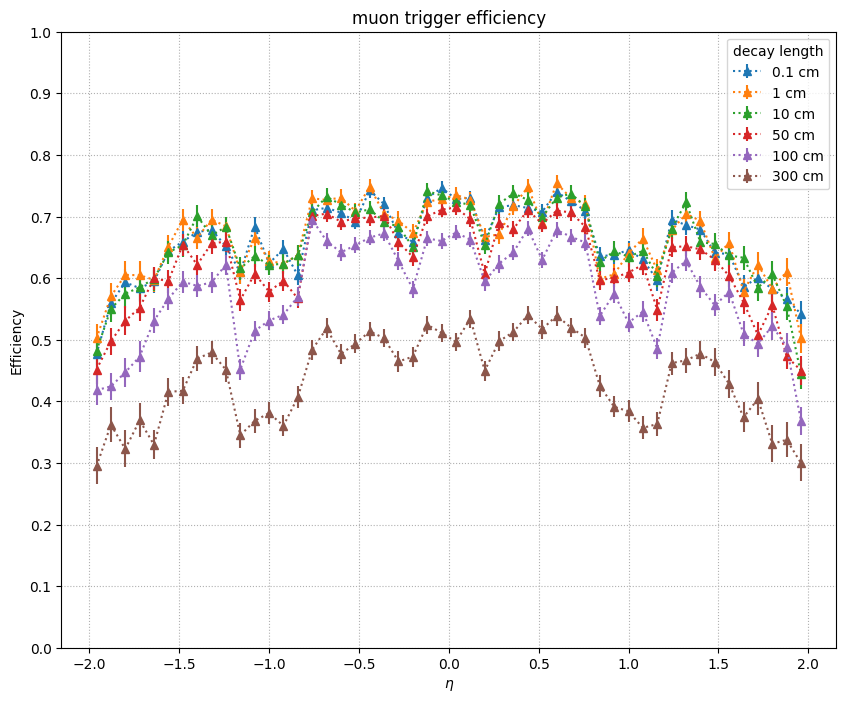

In [73]:
fig,ax = plt.subplots(figsize=(10,8))

for k, t in DL2Mu23CosmicT.items():
    d = t.array('eta')
    start = d.starts
    denom = d.content[start+1]
    fd = t.array('fired')
    numer = d.content[start[fd]+1]
    
    h0 = ROOT.TH1F(f'h0_{k}', '', 50, -2., 2.)
    h1 = ROOT.TH1F(f'h1_{k}', '', 50, -2., 2.)
    for x in np.nditer(denom): h0.Fill(x)
    for x in np.nditer(numer): h1.Fill(x)
        
    eff = ROOT.TEfficiency(h1, h0)
    data = extract_teffi(eff)

    ax.errorbar(x=data['x'], y=data['y'], yerr=data['yerr'], fmt='^:', label=f'{k} cm')
    
ax.set_title('muon trigger efficiency')
ax.set_xlabel('$\eta$')
ax.set_ylabel('Efficiency')
ax.yaxis.set_major_locator(plt.MaxNLocator(10))
ax.set_ylim((0,1))
ax.legend(loc='best', title='decay length')
ax.grid()

## Trigger `HLT_DoubleL2Mu23NoVtx_2Cha_CosmicSeed_NoL2Matched`

In [74]:
DL2Mu23CosmicNoL2T = OrderedDict({
    0.1 : uproot.open('../Firefighter/washAOD/test/2018/SIDMmumu_Mps-200_MZp-1p2_ctau-1p20e-03.root')['TRIG_dsa_DL2Mu23CosmicSeedNoL2/trigEffiForMuTrack'],
      1 : uproot.open('../Firefighter/washAOD/test/2018/SIDMmumu_Mps-200_MZp-1p2_ctau-0p012.root')   ['TRIG_dsa_DL2Mu23CosmicSeedNoL2/trigEffiForMuTrack'],
     10 : uproot.open('../Firefighter/washAOD/test/2018/SIDMmumu_Mps-200_MZp-1p2_ctau-0p12.root')    ['TRIG_dsa_DL2Mu23CosmicSeedNoL2/trigEffiForMuTrack'],
     50 : uproot.open('../Firefighter/washAOD/test/2018/SIDMmumu_Mps-200_MZp-1p2_ctau-0p6.root')     ['TRIG_dsa_DL2Mu23CosmicSeedNoL2/trigEffiForMuTrack'],
    100 : uproot.open('../Firefighter/washAOD/test/2018/SIDMmumu_Mps-200_MZp-1p2_ctau-1p2.root')     ['TRIG_dsa_DL2Mu23CosmicSeedNoL2/trigEffiForMuTrack'],
    300 : uproot.open('../Firefighter/washAOD/test/2018/SIDMmumu_Mps-200_MZp-1p2_ctau-3p6.root')     ['TRIG_dsa_DL2Mu23CosmicSeedNoL2/trigEffiForMuTrack']     
})

In [75]:
import pandas as pd
_dict = {}
for k, t in DL2Mu23CosmicNoL2T.items():
    _counts = t.pandas.df(['fired'])[b'fired'].value_counts()
    _counts /= _counts.sum()
    _dict[k] = _counts
pd.DataFrame(_dict)

,0.1,1.0,10.0,50.0,100.0,300.0
True,0.759677,0.763333,0.760659,0.739755,0.722422,0.659242
False,0.240323,0.236667,0.239341,0.260245,0.277578,0.340758


### Trigger `HLT_DoubleL2Mu23NoVtx_2Cha_CosmicSeed_NoL2Matched` Efficiency as a function of sub-leading $\mu$ $p_{T}$

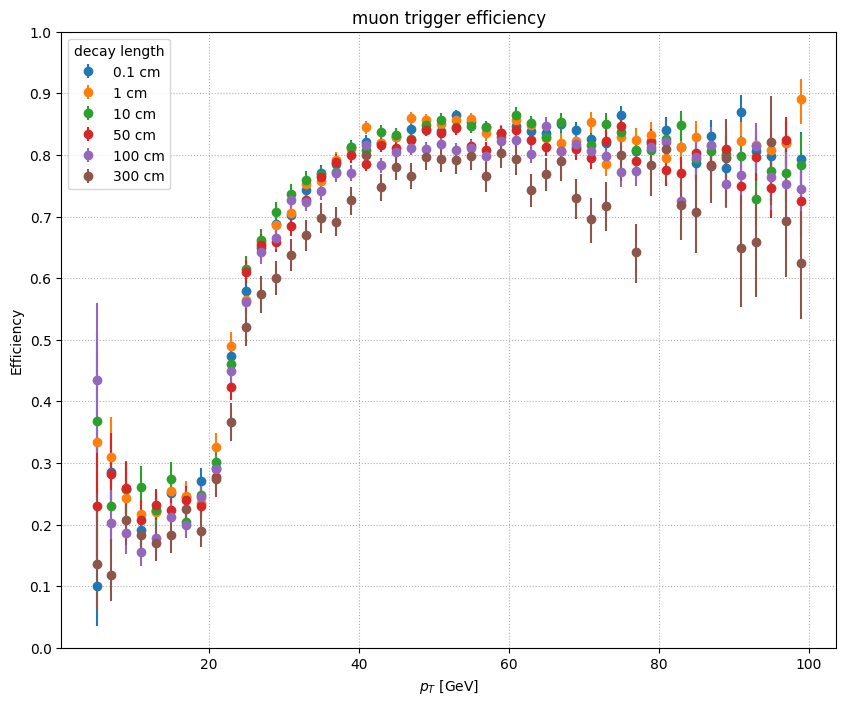

In [76]:
fig,ax = plt.subplots(figsize=(10,8))

for k, t in DL2Mu23CosmicNoL2T.items():
    d = t.array('pt')
    start = d.starts
    denom = d.content[start+1]
    fd = t.array('fired')
    numer = d.content[start[fd]+1]
    
    h0 = ROOT.TH1F(f'h0_{k}', '', 50, 0, 100)
    h1 = ROOT.TH1F(f'h1_{k}', '', 50, 0, 100)
    for x in np.nditer(denom): h0.Fill(x)
    for x in np.nditer(numer): h1.Fill(x)
        
    eff = ROOT.TEfficiency(h1, h0)
    data = extract_teffi(eff)

    ax.errorbar(x=data['x'], y=data['y'], yerr=data['yerr'], fmt='o', label=f'{k} cm')
    
ax.set_title('muon trigger efficiency')
ax.set_xlabel('$p_{T}$ [GeV]')
ax.set_ylabel('Efficiency')
ax.yaxis.set_major_locator(plt.MaxNLocator(10))
ax.set_ylim((0,1))
ax.legend(loc='best', title='decay length')
ax.grid()

### Trigger `HLT_DoubleL2Mu23NoVtx_2Cha_CosmicSeed_NoL2Matched` Efficiency as a function of sub-leading $\mu$ $\eta$

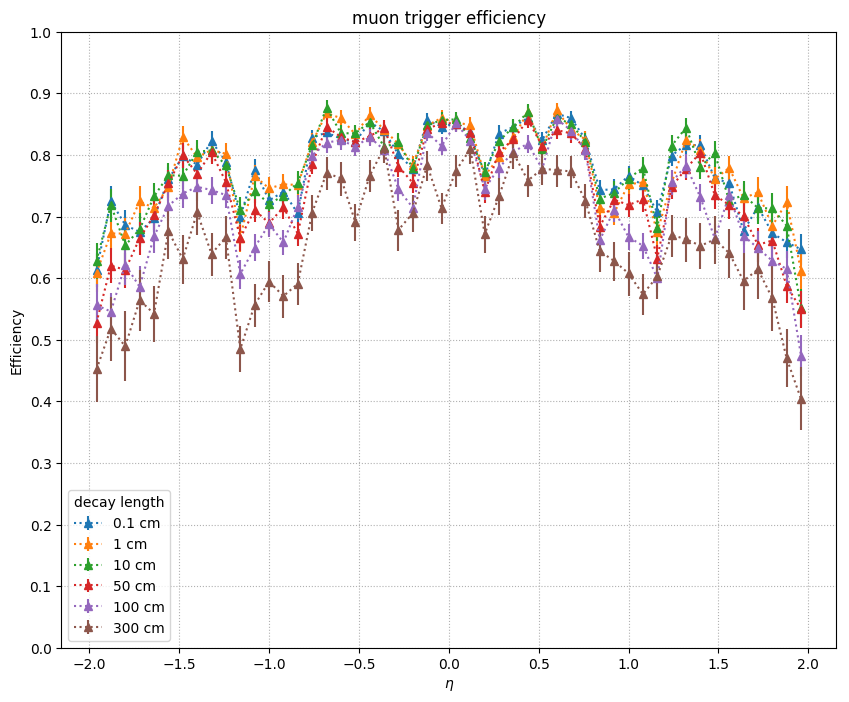

In [77]:
fig,ax = plt.subplots(figsize=(10,8))

for k, t in DL2Mu23CosmicNoL2T.items():
    d = t.array('eta')
    start = d.starts
    denom = d.content[start+1]
    fd = t.array('fired')
    numer = d.content[start[fd]+1]
    
    h0 = ROOT.TH1F(f'h0_{k}', '', 50, -2., 2.)
    h1 = ROOT.TH1F(f'h1_{k}', '', 50, -2., 2.)
    for x in np.nditer(denom): h0.Fill(x)
    for x in np.nditer(numer): h1.Fill(x)
        
    eff = ROOT.TEfficiency(h1, h0)
    data = extract_teffi(eff)

    ax.errorbar(x=data['x'], y=data['y'], yerr=data['yerr'], fmt='^:', label=f'{k} cm')
    
ax.set_title('muon trigger efficiency')
ax.set_xlabel('$\eta$')
ax.set_ylabel('Efficiency')
ax.yaxis.set_major_locator(plt.MaxNLocator(10))
ax.set_ylim((0,1))
ax.legend(loc='best', title='decay length')
ax.grid()

### trigger efficiency itself

In [78]:
DL2Mu23CosmicNoL2T = OrderedDict({
    0.1 : uproot.open('../Firefighter/washAOD/test/2018/SIDMmumu_Mps-200_MZp-1p2_ctau-1p20e-03.root')['TRIGself_dsa_DL2Mu23CosmicSeedNoL2/trigSelfEffiForMuTrack'],
      1 : uproot.open('../Firefighter/washAOD/test/2018/SIDMmumu_Mps-200_MZp-1p2_ctau-0p012.root')   ['TRIGself_dsa_DL2Mu23CosmicSeedNoL2/trigSelfEffiForMuTrack'],
     10 : uproot.open('../Firefighter/washAOD/test/2018/SIDMmumu_Mps-200_MZp-1p2_ctau-0p12.root')    ['TRIGself_dsa_DL2Mu23CosmicSeedNoL2/trigSelfEffiForMuTrack'],
     50 : uproot.open('../Firefighter/washAOD/test/2018/SIDMmumu_Mps-200_MZp-1p2_ctau-0p6.root')     ['TRIGself_dsa_DL2Mu23CosmicSeedNoL2/trigSelfEffiForMuTrack'],
    100 : uproot.open('../Firefighter/washAOD/test/2018/SIDMmumu_Mps-200_MZp-1p2_ctau-1p2.root')     ['TRIGself_dsa_DL2Mu23CosmicSeedNoL2/trigSelfEffiForMuTrack'],
    300 : uproot.open('../Firefighter/washAOD/test/2018/SIDMmumu_Mps-200_MZp-1p2_ctau-3p6.root')     ['TRIGself_dsa_DL2Mu23CosmicSeedNoL2/trigSelfEffiForMuTrack']     
})

0.1      0.866638
1.0      0.865816
10.0     0.864328
50.0     0.842689
100.0    0.811871
300.0    0.737713
dtype: float64


Info in <TBinomialEfficiencyFitter::result>:  chi2 186.620032 ndf 0 
Info in <TBinomialEfficiencyFitter::result>:  chi2 158.639475 ndf 0 
Info in <TBinomialEfficiencyFitter::result>:  chi2 183.899165 ndf 0 
Info in <TBinomialEfficiencyFitter::result>:  chi2 233.781923 ndf 0 
Info in <TBinomialEfficiencyFitter::result>:  chi2 174.509360 ndf 0 
Info in <TBinomialEfficiencyFitter::result>:  chi2 112.767432 ndf 0 


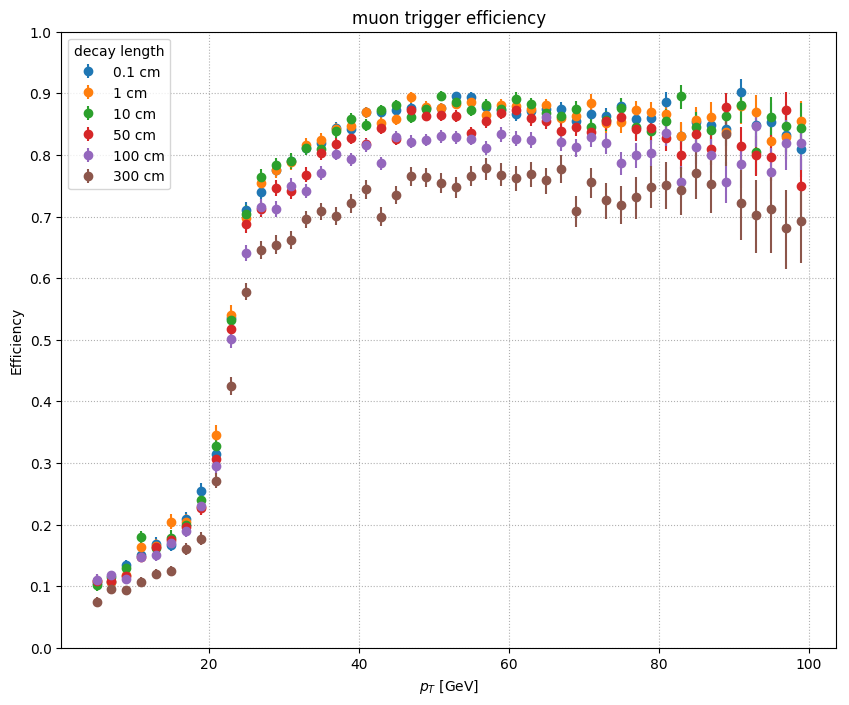

In [79]:
fig,ax = plt.subplots(figsize=(10,8))

fitResult = {}
for k, t in DL2Mu23CosmicNoL2T.items():
    d = t.array('pt')
    start = d.starts
    denom = d.content[start+1]
    fd = t.array('fired')
    numer = d.content[start[fd]+1]
    
    h0 = ROOT.TH1F(f'h0_{k}', '', 50, 0, 100)
    h1 = ROOT.TH1F(f'h1_{k}', '', 50, 0, 100)
    for x in np.nditer(denom): h0.Fill(x)
    for x in np.nditer(numer): h1.Fill(x)
        
    eff = ROOT.TEfficiency(h1, h0)
    data = extract_teffi(eff)
    fitResult[k] = extract_fitParam_from_teffi(eff)

    ax.errorbar(x=data['x'], y=data['y'], yerr=data['yerr'], fmt='o', label=f'{k} cm')
    
ax.set_title('muon trigger efficiency')
ax.set_xlabel('$p_{T}$ [GeV]')
ax.set_ylabel('Efficiency')
ax.yaxis.set_major_locator(plt.MaxNLocator(10))
ax.set_ylim((0,1))
ax.legend(loc='best', title='decay length')
ax.grid()

print(pd.Series({k: fitResult[k][2]+fitResult[k][3] for k in fitResult}))

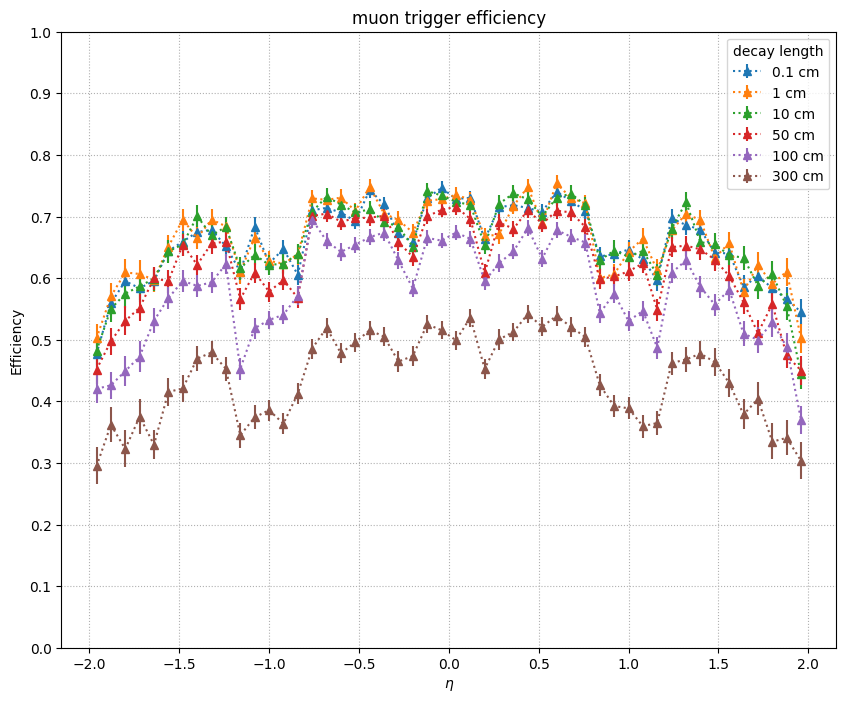

In [80]:
fig,ax = plt.subplots(figsize=(10,8))

for k, t in DL2Mu23CosmicNoL2T.items():
    d = t.array('eta')
    start = d.starts
    denom = d.content[start+1]
    fd = t.array('fired')
    numer = d.content[start[fd]+1]
    
    h0 = ROOT.TH1F(f'h0_{k}', '', 50, -2., 2.)
    h1 = ROOT.TH1F(f'h1_{k}', '', 50, -2., 2.)
    for x in np.nditer(denom): h0.Fill(x)
    for x in np.nditer(numer): h1.Fill(x)
        
    eff = ROOT.TEfficiency(h1, h0)
    data = extract_teffi(eff)

    ax.errorbar(x=data['x'], y=data['y'], yerr=data['yerr'], fmt='^:', label=f'{k} cm')
    
ax.set_title('muon trigger efficiency')
ax.set_xlabel('$\eta$')
ax.set_ylabel('Efficiency')
ax.yaxis.set_major_locator(plt.MaxNLocator(10))
ax.set_ylim((0,1))
ax.legend(loc='best', title='decay length')
ax.grid()

## Trigger efficiency as a function of decay length

,0.1,1.0,10.0,50.0,100.0,300.0
HLT_DoubleL2Mu23NoVtx_2Cha,0.931387,0.932071,0.930657,0.917863,0.905938,0.843255
HLT_DoubleL2Mu23NoVtx_2Cha_NoL2Matched,0.933000,0.933949,0.932275,0.919285,0.908945,0.849741
HLT_DoubleL2Mu23NoVtx_2Cha_CosmicSeed,0.866415,0.865395,0.863718,0.842421,0.810814,0.734964
HLT_DoubleL2Mu23NoVtx_2Cha_CosmicSeed_NoL2Matched,0.866638,0.865816,0.864328,0.842689,0.811871,0.737713


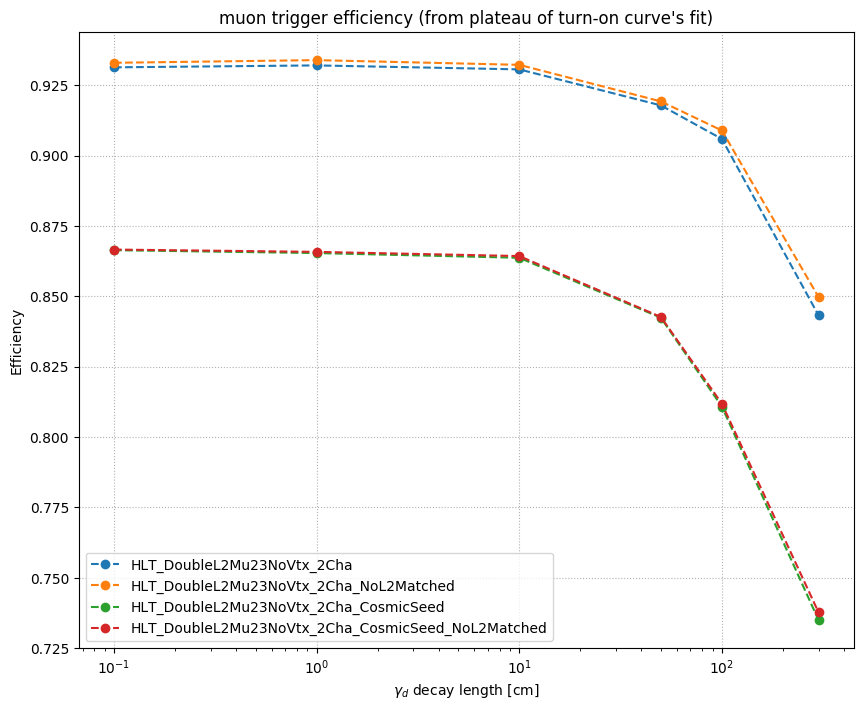

In [81]:
dl = np.array([0.1, 1.0, 10., 50., 100., 300.])
eff = {
    'HLT_DoubleL2Mu23NoVtx_2Cha':                        np.array([0.931387, 0.932071, 0.930657, 0.917863, 0.905938, 0.843255]),
    'HLT_DoubleL2Mu23NoVtx_2Cha_NoL2Matched':            np.array([0.933000, 0.933949, 0.932275, 0.919285, 0.908945, 0.849741]),
    'HLT_DoubleL2Mu23NoVtx_2Cha_CosmicSeed':             np.array([0.866415, 0.865395, 0.863718, 0.842421, 0.810814, 0.734964]),
    'HLT_DoubleL2Mu23NoVtx_2Cha_CosmicSeed_NoL2Matched': np.array([0.866638, 0.865816, 0.864328, 0.842689, 0.811871, 0.737713])
}

fig, ax = plt.subplots(figsize=(10,8))

for l, v in eff.items():
    ax.semilogx(dl, v, 'o--', label=l)
ax.legend(loc='best')
ax.set_title("muon trigger efficiency (from plateau of turn-on curve's fit)")
ax.set_xlabel('$\gamma_{d}$ decay length [cm]')
ax.set_ylabel('Efficiency')
ax.grid()
# ax.set_ylim((0,1))

pd.DataFrame(data=eff, index=dl).T